# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install --q segmentation-models-pytorch
!pip install -U --q git+https://github.com/albumentations-team/albumentations
!pip install --upgrade --q opencv-contrib-python

     |████████████████████████████████| 97 kB 4.0 MB/s 
     |████████████████████████████████| 376 kB 30.6 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

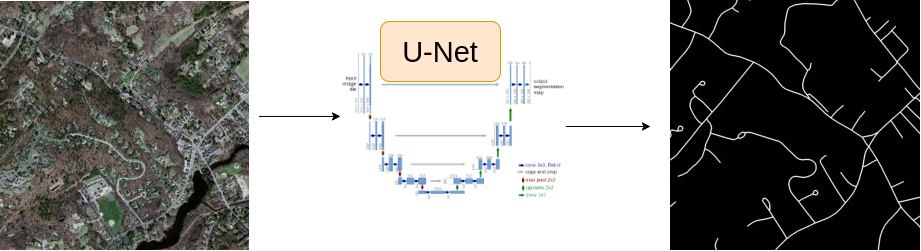

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 41.76 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 3e-3
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [6]:
df = pd.read_csv(CSV_FILE)
df.shape

(199, 2)

In [7]:
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

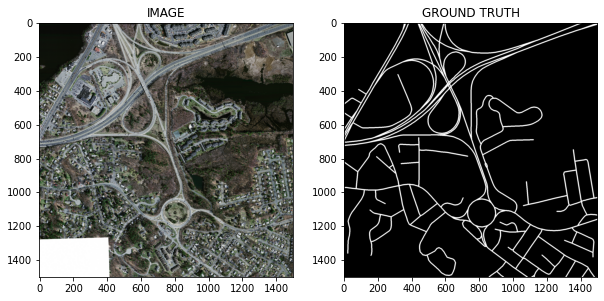

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])


def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ])

# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [59]:
class SermentationDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df.reset_index(drop=True)
        self.augmentations = augmentations

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations is not None:
            data = self.augmentations(image=image, mask=mask,)
            image = data['image']
            mask = data['mask']

        image = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1) / 255.0
        mask = torch.round(
            torch.from_numpy(mask.astype(np.float32)).permute(2, 0, 1) / 255.0
        )

        return image, mask

In [60]:
trainset = SermentationDataset(train_df, augmentations=get_train_augs())
validset = SermentationDataset(valid_df, augmentations=get_valid_augs())

In [61]:
print(f'Total examples in the trainset: {len(trainset)}')
print(f'Total examples in the validset: {len(validset)}')

Total examples in the trainset: 159
Total examples in the validset: 40


dict_keys(['image', 'mask'])


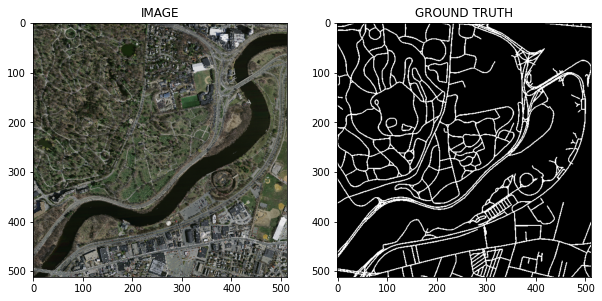

In [50]:
idx = 60

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [62]:
from torch.utils.data import DataLoader

In [63]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 20
Total no. batches in validloader : 5


In [65]:
images, masks = next(iter(trainloader))


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(masks.shape))

Shape of one batch images : torch.Size([8, 3, 512, 512])
Shape of one batch bboxes : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [66]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [67]:
class SegmentationModel(nn.Module):
    def __init__(
        self, encoder_name, encoder_weights,
        in_channels=3, num_classes=1, activation=None,
    ):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=encoder_name, encoder_weights=encoder_weights,
             in_channels=in_channels, classes=num_classes,
             activation=activation,
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if mask is not None:
            loss = DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss
        return logits

In [68]:
model = SegmentationModel(encoder_name=ENCODER, encoder_weights=WEIGHTS)
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [69]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()

    for data in tqdm(dataloader):
        images, masks = data
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        bboxes, loss = model(images, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [70]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, masks = data
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            bboxes, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    optimizer.zero_grad()
    
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch: {i+1}; train loss: {train_loss}; valid loss: {valid_loss};')

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch: 1; train loss: 1.188831201195717; valid loss: 1.082053780555725;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 2; train loss: 0.7888045370578766; valid loss: 0.8005396604537964;


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 3; train loss: 0.7056315630674362; valid loss: 0.7413573741912842;


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 4; train loss: 0.6707673907279968; valid loss: 0.7164718031883239;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 5; train loss: 0.6612123101949692; valid loss: 0.7648589968681335;


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 6; train loss: 0.6498698741197586; valid loss: 0.9100617408752442;


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 7; train loss: 0.6430747181177139; valid loss: 0.7041247725486756;


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch: 8; train loss: 0.6257450371980667; valid loss: 0.705981969833374;


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 9; train loss: 0.6212717980146408; valid loss: 0.6387852668762207;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 10; train loss: 0.6113754004240036; valid loss: 0.659419596195221;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 11; train loss: 0.6032225236296653; valid loss: 0.6406752824783325;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 12; train loss: 0.604476273059845; valid loss: 0.6921963095664978;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 13; train loss: 0.5831470280885697; valid loss: 0.6434553503990174;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 14; train loss: 0.5885362416505814; valid loss: 0.6588101387023926;


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 15; train loss: 0.5792859584093094; valid loss: 0.6369831919670105;


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch: 16; train loss: 0.582896976172924; valid loss: 0.7106756925582886;


 85%|████████▌ | 17/20 [00:19<00:03,  1.16s/it]

# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, masks = validset[1]
    image = image.unsqueeze(0).to(DEVICE)
    logits_mask = model(image)
    pred_mask = (torch.sigmoid(logits_mask) > 0.5) * 1.0
    pred_mask = pred_mask.detach().cpu().squeeze(0)

In [ ]:
helper.show_image(image, mask, pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

